In [ ]:
%pip install inferactively-pymdp

In [ ]:
import pymdp
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

**Stage 1:** Huddling

In [ ]:
# States: Belonging - Group1, Group2
# Observations: Same group or Other group
# Actions: Contact, No Contact

class Huddling:
  def __init__(self, alpha):
    n_states = 2
    n_actions = 2
    num_observations = 2

    self.pups = np.array([0, 0, 1, 1]) # Huddle that pup belongs to
    # Creating the likelihood matrix
    # P(o|s)
    A_matrix = np.array([[0.9, 0.1], [0.1, 0.9]])
    # Creating the transition matrix
    # P(s_t|s_{t-1}, Contact)
    B1 = np.array([[0.9, 0.1],[0.1, 0.9]])
    # P(s_t|s_{t-1}, No contact)
    B2 = np.array([[0.3, 0.7],[0.7, 0.3]])
    B_matrix = np.zeros((n_states, n_states, n_actions))
    B_matrix[:, :, 0] = B1
    B_matrix[:, :, 1] = B2
    B_matrix = utils.norm_dist(B_matrix)
    self.agent = Agent( A = A_matrix, B = B_matrix, C = alpha)

    self.state = {'obs': [], 'action': [], 'posterior': []}
    self.action = [0]
    self.obs = [0]
    self.lr = 0.03


  def step_huddling( self, T, alpha ):
    p = lambda T: 1.0/(1 + np.exp(-T))
    # Pick two pups at random
    pup = np.random.choice(self.pups)
    Ta = 2*alpha*T

    return [pup if p(Ta) > 0.5 else 1 - pup]

  def step( self, T, alpha ):
    # Inference
    self.obs = self.step_huddling( T, alpha[int(self.obs[0])]*(1-self.action[0]) )
    qs = self.agent.infer_states( self.obs )

    # Action
    q_pi, neg_efe = self.agent.infer_policies()
    self.action = self.agent.sample_action()

    alpha[int(self.obs[0])] += self.lr*(1 - self.action[0] - alpha[1-int(self.obs[0])])*1.0
    alpha = utils.norm_dist(alpha*(alpha > 0))
    self.agent.C[0] = alpha

    self.state['obs'] = self.obs
    self.state['action'] = self.action[0]
    self.state['posterior'] = qs[0]

    return alpha

  def print_state(self):
    print(f'Observation: {self.state["obs"]}')
    print(f'Action: {self.state["action"]}')
    print(f'Posterior: {self.state["posterior"]}')



**Stage 2:** Discomfort

In [ ]:
# States: S1 = A Happy, S2 = A sad, S3 - B happy, S4 - B sad
# Observation: G1 (cry, squeak), G2 (cry, squeak)
# Action: help_A (0)/ help_B (1) / no help (2)

class Altruism:
  def __init__(self, alpha):
    n_states = 4
    n_observations = 4
    n_actions = 3
    self.adults = np.array([1, 1]) # sad/happy

    # Matrices
    # A - Acry, Asqueak, Bcry, Bsqueak
    A_matrix = utils.norm_dist(np.array(
                        [[0.3, 0.7, 0.0, 0.0],
                        [0.7, 0.3, 0.0, 0.0],
                        [0.0, 0.0, 0.3, 0.7],
                        [0.0, 0.0, 0.7, 0.3]])) # Try altruistic and non altruistic matrices
    # B
    B1 = np.array([[0.9, 0.9, 0.0, 0.0],
                  [0.1, 0.1, 0.0, 0.0],
                  [0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0]]) # Help A
    B2 = np.array([[1.0, 0.0, 0.0, 0.0],
                  [0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.9, 0.9],
                  [0.0, 0.0, 0.1, 0.1]]) # Help B
    B3 = np.array([[0.1, 0.1, 0.0, 0.0],
                  [0.9, 0.9, 0.0, 0.0],
                  [0.0, 0.0, 0.1, 0.1],
                  [0.0, 0.0, 0.9, 0.9]]) # No Help
    B_matrix = np.zeros((n_states, n_states, n_actions))
    B_matrix[:, :, 0] = B1
    B_matrix[:, :, 1] = B2
    B_matrix[:, :, 2] = B3
    B_matrix = utils.norm_dist(B_matrix)
    # C_vector =  np.ones(n_observations)#
    C_vector =  np.array([0, alpha[0], 0, alpha[1]])
    self.agent = Agent( A = A_matrix, B = B_matrix, C = utils.norm_dist(C_vector))

    self.state = {'obs': [], 'action': [], 'posterior': []}


  def step_environment( self ):
    ind = np.random.randint(2)
    self.adults[ind] = 0
    ind = np.random.randint(2)

    return [2*ind + self.adults[ind]]

  def step( self, alpha ):

    obs = self. step_environment()
    qs = self.agent.infer_states( obs )
    # Action
    q_pi, neg_efe = self.agent.infer_policies()
    action = self.agent.sample_action()

    if action[0] == 0 and obs[0] == 0:
      self.adults[0] = 1
    if action[0] == 1 and obs[0] == 2:
      self.adults[1] = 1

    self.state['obs'] = obs
    self.state['action'] = action[0]
    self.state['posterior'] = qs[0]

    return self.adults

  def print_state(self):
    print(f'Observation: {self.state["obs"]}')
    print(f'Action: {self.state["action"]}')
    print(f'Posterior: {self.state["posterior"]}')


**Stage 0:** Developmental process

In [ ]:
# BAT -> Environment
# States (Stage1, Stage2)
# Observations (T1, T2)

class Development:

  def step_environment( self, t ):
    beta = 0.03
    bat = lambda t: np.exp(-beta*t) + np.random.randn()*0.01
    return bat(t), [int(bat(t) > 0.5)]

  def __init__(self):
    num_states = 2
    num_observations = 2
    num_actions = 2
    A_matrix = np.array([[0.9, 0.1],
                        [0.1, 0.9]])
    B1 = np.array([[0.9, 0.5],
                   [0.1, 0.5]])
    B2 = np.array([[0.5, 0.1],
                   [0.5, 0.9]])
    B_matrix = np.zeros((num_states, num_states, num_actions))
    B_matrix[:,:,0] = B1
    B_matrix[:,:,1] = B2

    B_matrix = utils.norm_dist(B_matrix)
    C_vector = np.ones(2)/np.sqrt(2)
    self.agent = Agent( A = A_matrix, B = B_matrix, C = C_vector)
    self.alpha0 = np.ones(2)/np.sqrt(2)
    self.huddling = Huddling( self.alpha0 )
    self.altruism = None

    self.state = {'obs': [], 'action': [], 'posterior': []}

  def step( self, t, alpha, transfer = True ):

    bat, obs = self.step_environment( t )
    qs = self.agent.infer_states( obs )

    q_pi, neg_efe = self.agent.infer_policies()
    action = self.agent.sample_action()

    adult_state = np.array([0, 0])

    if action[0] == 0:
      alpha = self.huddling.step( 40, alpha )
    else:
      if not transfer: # Carry on the associations?
        alpha = self.alpha0

      if self.altruism == None:
        self.altruism = Altruism(alpha)

      adult_state = self.altruism.step(alpha)

    return bat, 1-np.argmax(qs[0]), alpha, adult_state

**Running the simulation**

Text(0.5, 1.0, 'Frequency of comfort states per group')

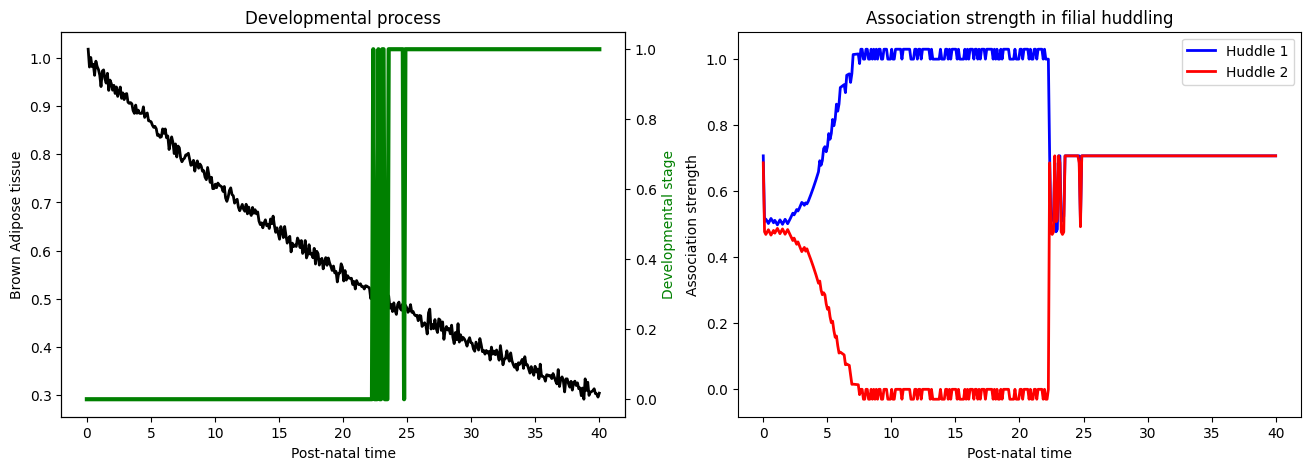

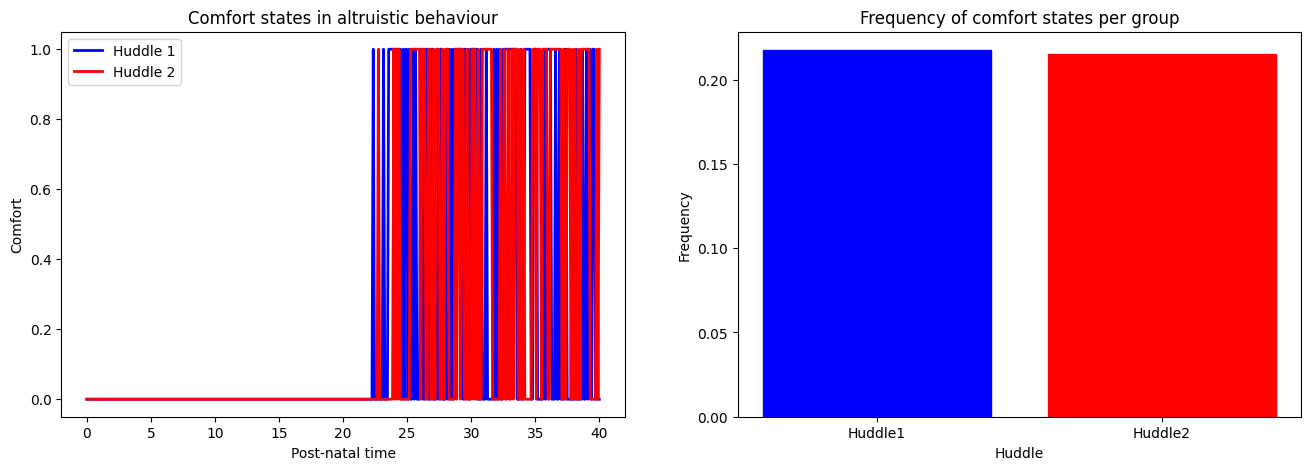

In [ ]:
N = 400
t = np.linspace(0, 40, N)

development = Development()

bats = np.zeros(N)
stages = np.zeros(N)
associations = np.zeros((2, N))
adult_states = np.zeros((2, N))
associations[:, 0] = development.alpha0

for i in range(N-1):
  bat, stage, alpha, adult_state = development.step(t[i], associations[:,i], transfer = False)

  bats[i+1] = bat
  stages[i+1] = stage
  associations[:, i+1] = alpha
  adult_states[:, i+1] = adult_state

plt.rcParams['figure.figsize'] = [16, 5]
figure, ax = plt.subplots(1, 2)


ax[0].plot(t[1:], bats[1:], 'k', linewidth = 2)
ax2 = ax[0].twinx()
ax2.plot(t, stages, 'g', linewidth = 3)
ax[0].set_xlabel('Post-natal time')
ax[0].set_ylabel('Brown Adipose tissue')
ax2.set_ylabel('Developmental stage', color = 'g')
ax[0].set_title('Developmental process')

ax[1].plot( t, associations[0, :], 'b', linewidth = 2, label = 'Huddle 1')
ax[1].plot( t, associations[1, :], 'r', linewidth = 2, label = 'Huddle 2')
ax[1].set_xlabel( 'Post-natal time')
ax[1].set_ylabel( 'Association strength')
ax[1].legend()
ax[1].set_title('Association strength in filial huddling')

figure, ax = plt.subplots(1, 2)

ax[0].plot( t, adult_states[0, :], 'b', linewidth = 2, label = 'Huddle 1')
ax[0].plot( t, adult_states[1, :], 'r', linewidth = 2, label = 'Huddle 2')
ax[0].set_xlabel( 'Post-natal time')
ax[0].set_ylabel( 'Comfort')
ax[0].legend()
ax[0].set_title('Comfort states in altruistic behaviour')

bars = ax[1].bar([0, 1], np.sum(adult_states, 1)/N)
bars[0].set_color('b')
bars[1].set_color('r')
ax[1].set_xlabel('Huddle')
ax[1].set_xticks([0, 1], labels = ['Huddle1', 'Huddle2'])
ax[1].set_ylabel('Frequency')
ax[1].set_title('Frequency of comfort states per group')
